In [5]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

In [6]:
plt.style.use("ggplot")

In [7]:
from keras.models import Sequential
from keras.layers import Embedding , LSTM , Dense , Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [8]:
train_data = pd.read_csv('train.txt' , header = None , sep=";" , names = ['Comment' , 'Emotion'] , encoding = 'utf-8')

In [9]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [10]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [11]:
train_data.shape

(16000, 3)

In [12]:
train_data.isnull().sum()

,0
Comment,0
Emotion,0
length,0


In [13]:
train_data.duplicated().sum()

np.int64(1)

## EDA

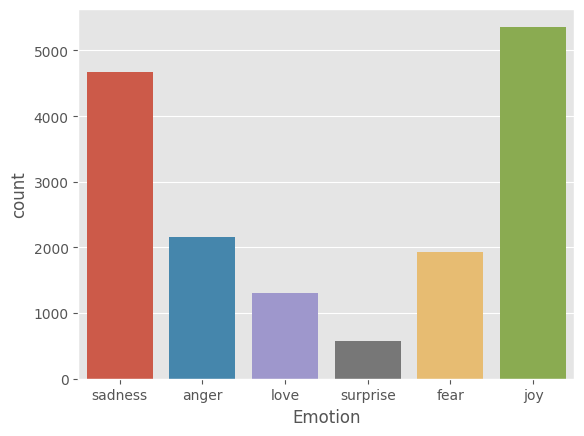

In [14]:
sns.countplot(x=train_data['Emotion'], hue=train_data['Emotion'])
plt.show()

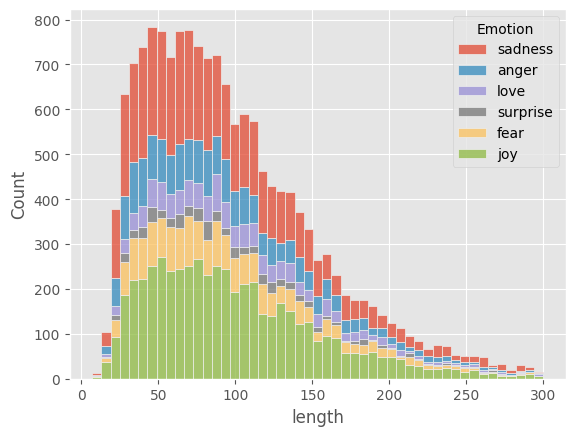

In [15]:
df2 = train_data.copy()
df2['length'] = [len(x) for x in train_data['Comment']]
length_value = df2['length'].values
sns.histplot(data=df2, x='length',hue='Emotion',multiple = 'stack')
plt.show()

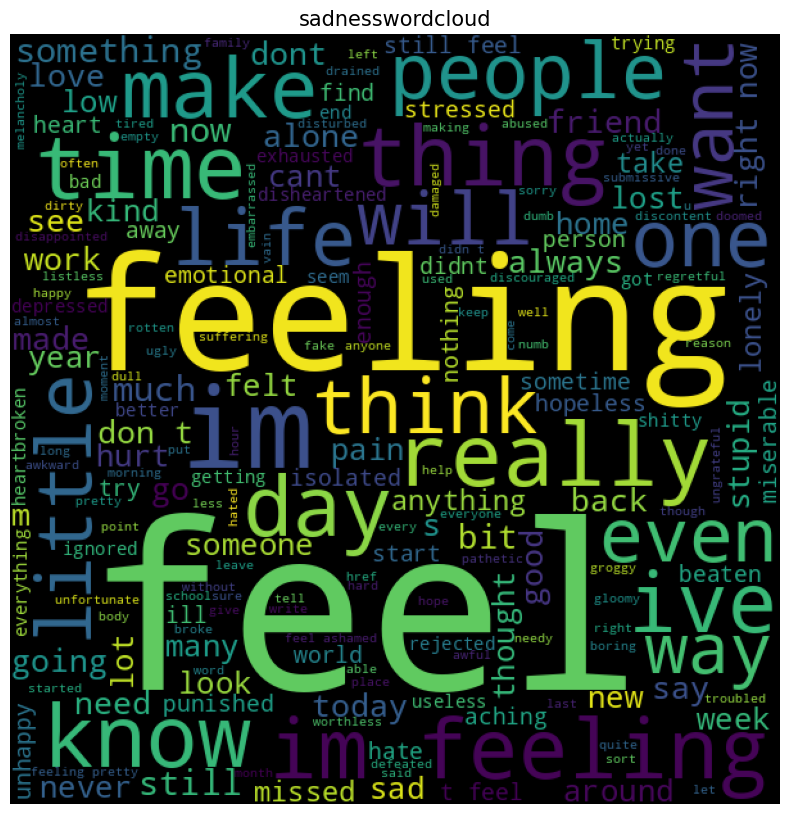

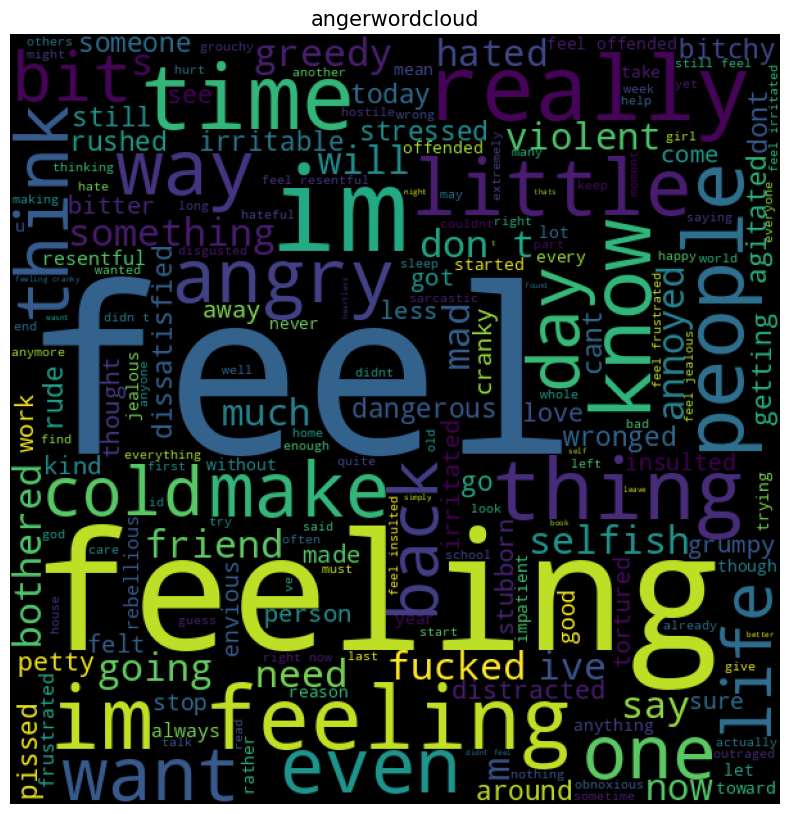

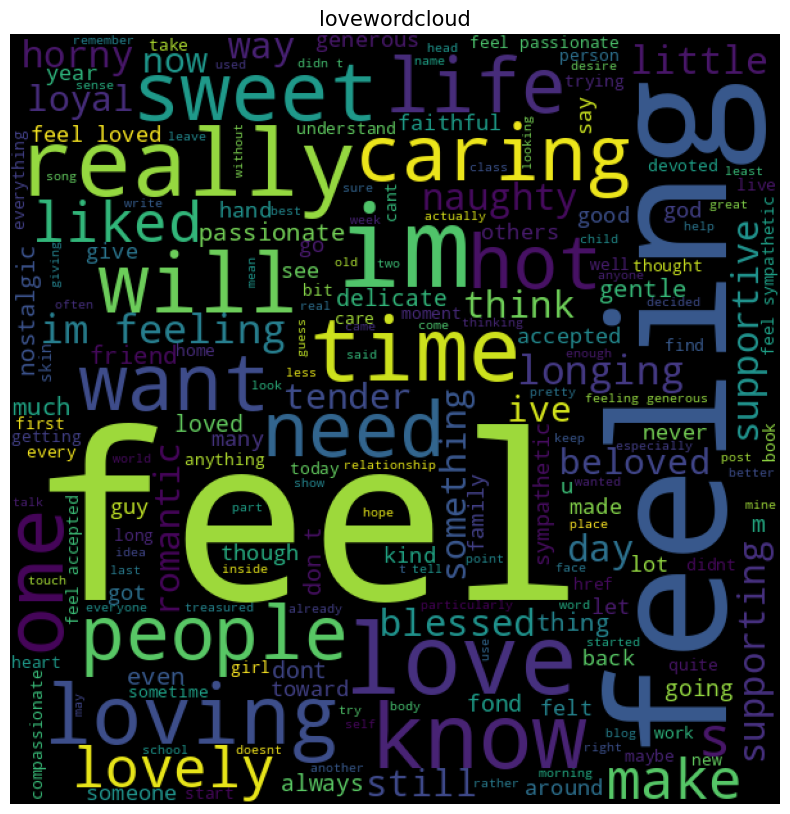

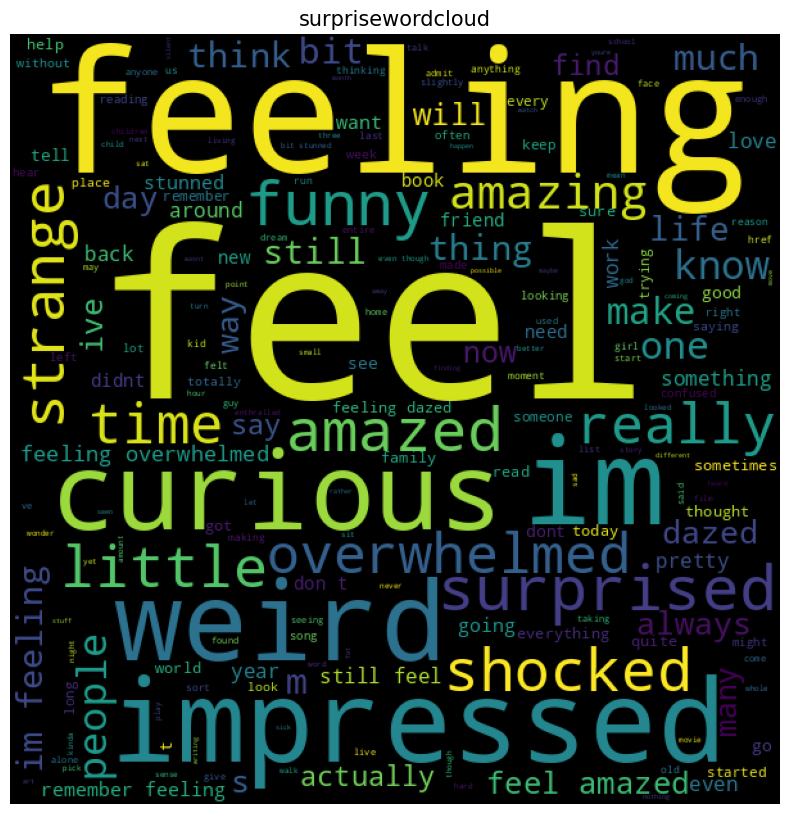

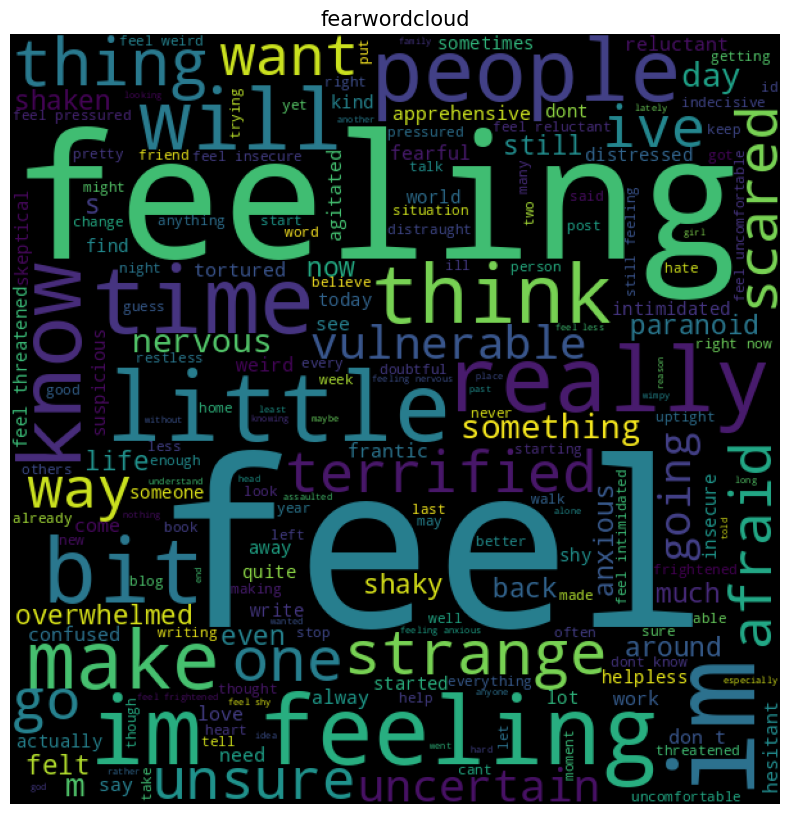

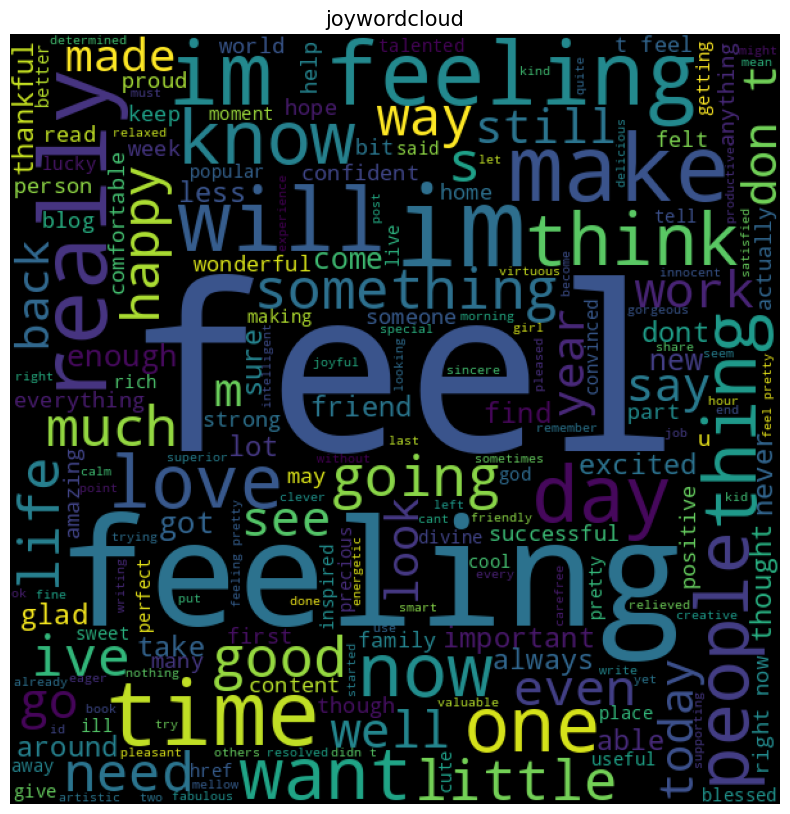

In [16]:
def words_cloud(wordcloud,df):
  plt.figure(figsize=(10,10))
  plt.title(df + 'wordcloud' , size=15)
  plt.imshow(wordcloud)
  plt.axis("off")

emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
  text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion']== emotion , 'Comment']])
  wordcloud = WordCloud(width=600 , height=600).generate(text)
  words_cloud(wordcloud, emotion)

## Data Preprocessing

In [17]:
lb = LabelEncoder()

train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [18]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , classification_report

In [20]:
df = train_data.copy()

In [21]:
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [22]:
from tqdm import tqdm
tqdm.pandas()
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))

def clean_data(text):
  stemmer = PorterStemmer()
  text = re.sub("[^a-zA-Z]" , " ",text)
  text = text.lower()
  text = text.split()
  text = [stemmer.stem(word) for word in text if word not in stopwords]
  return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
df['cleaned_comment'] = df['Comment'].progress_apply(clean_data)

100%|██████████| 16000/16000 [00:02<00:00, 6565.34it/s]


In [24]:
df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


In [25]:
X_train , X_test , y_train , y_test = train_test_split(df['cleaned_comment'] , df['Emotion'] , test_size=0.2 , random_state=42)

In [27]:
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [28]:
X_train_tfidf.shape

(12800, 9257)

In [29]:
X_test_tfidf.shape

(3200, 9257)

In [30]:
classifier = {
    'MultinomialNB' : MultinomialNB(),
    'LogisticRegression' : LogisticRegression(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'SVC' : SVC()
}

for name,clf in classifier.items():
  print(f"============{name}==============")
  clf.fit(X_train_tfidf , y_train)
  y_pred_tfidf = clf.predict(X_test_tfidf)
  accuracy_tfidf = accuracy_score(y_test , y_pred_tfidf)
  print(f"=========={accuracy_tfidf}==========")
  print("Classification Report")
  print(classification_report(y_test , y_pred_tfidf))

============MultinomialNB==============
==========0.655==========
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200

============LogisticRegression==============
==========0.829375==========
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
  

In [31]:
lg = LogisticRegression()
lg.fit(X_train_tfidf , y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [32]:
def predict_emotion(input_text):
  cleaned_text = clean_data(input_text)
  input_vectorizer = tfidfvectorizer.transform([cleaned_text])

  predicted_label = lg.predict(input_vectorizer)[0]
  predicted_emotion = lb.inverse_transform([predicted_label])[0]
  label = np.max(lg.predict(input_vectorizer))

  return predicted_emotion , label

In [33]:
predict_emotion("She breakup with me")

('sadness', np.int64(4))

In [35]:
predict_emotion("I am happy now")

('joy', np.int64(2))

In [39]:
predict_emotion("im grabbing a minute to post i feel greedy wrong	")

('anger', np.int64(0))

In [34]:
import pickle
pickle.dump(lg , open("logistic_regression.pkl" , "wb"))
pickle.dump(lb , open("label_encoder.pkl" , "wb"))
pickle.dump(tfidfvectorizer , open("tfidfvectorizer.pkl" , "wb"))

## Applying Deep Learning using LSTM

In [42]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ",text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    return pad

In [43]:
X_train = text_cleaning(train_data, 'Comment' , vocab_size=11000, max_len=300)
y_train = to_categorical(train_data['Emotion'])

In [44]:
model = Sequential()
model.add(Embedding(input_dim=11000 , output_dim=150 , input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(6 , activation = "softmax"))
model.compile(optimizer="adam" , loss = "categorical_crossentropy" , metrics=['accuracy'])


callback = EarlyStopping(monitor="val_loss" , patience=2 , restore_best_weights=True)
model.fit(X_train , y_train , epochs=1 , batch_size=64 , verbose=1 , callbacks=[callback])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3724 - loss: 1.5792


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


In [45]:
model.save("model.h5")

In [46]:
from keras.models import load_model
model01 = load_model("model.h5")

In [47]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [49]:
sentence = predictive_system_dl("I am feeling happy")
result = lb.inverse_transform(np.argmax(model.predict(sentence) , axis=1))[0]
prob = np.max(model01.predict(sentence))

print(f"{result} with probability {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
joy with probability 0.709627091884613


In [53]:
with open("lb1.pkl","wb") as f:
  pickle.dump(lb , f)
vocab_info = {"vocab_size":11000,"max_len":300}
with open("vocab_info.pkl","wb") as f:
  pickle.dump(vocab_info , f)